# Neuroscope

Jupyter workspace for the neuroscope project

In [1]:
import jax
from jax import vmap, jit, lax, random, grad, value_and_grad
import jax.numpy as jnp
import optax

import wandb
import numpy as np
from functools import partial
from tqdm import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt

import syrkis
from src.data import load_subject, make_kfolds

In [2]:
# GLOBALS
rng = random.PRNGKey(0)
cfg = syrkis.training.load_config()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-11-20 22:08:51.202607: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


## Data

In [3]:
if 'subject' not in locals():
    subject = load_subject('subj07', image_size=cfg['image_size'])
    kfolds = make_kfolds(subject, cfg)
    batches, neuroscope_eval_batches = next(kfolds)  # type: ignore
    lh_sample, rh_sample, img_sample = next(batches)

In [4]:
def glorot_init(rng, shape):
    if len(shape) == 2:  # Dense layer
        fan_in, fan_out = shape
    elif len(shape) == 4:  # Convolutional layer
        fan_in = shape[0] * shape[1] * shape[2]  # kernel_height * kernel_width * in_channels
        fan_out = shape[0] * shape[1] * shape[3]  # kernel_height * kernel_width * out_channels
    limit = jnp.sqrt(6 / (fan_in + fan_out))
    return jax.random.uniform(rng, shape, minval=-limit, maxval=limit)


def latent_side_fn(cfg):
    return cfg['image_size'] // cfg['stride'] ** cfg['conv_layers']

def latent_dim_fn(cfg):
    # should return the size of the latente dim depending on initial image size, stride, and number of layers, and channels
    image_size = cfg['image_size']
    stride = cfg['stride']
    layers = cfg['conv_layers']
    channels = 3 if cfg['dataset'] == 'neuroscope' else 1
    if stride == 1:
        latent_dim = image_size ** 2 * channels * 2 ** layers
    if stride == 2:
        latent_dim = image_size ** 2 * channels // (stride ** layers)
    # Multiply by 2 because of bug (this is a temporary fix)
    return latent_dim


latent_dim = latent_dim_fn(cfg)
latent_side = latent_side_fn(cfg)


## Batch norm

In [5]:
@jit
def batch_norm(x, gamma, beta, eps=1e-5):
    # x: batch x height x width x channels
    axis = tuple(range(len(x.shape) - 1))
    mean = jnp.mean(x, axis=axis, keepdims=True)
    var = jnp.var(x, axis=axis, keepdims=True)
    x = (x - mean) / jnp.sqrt(var + eps)
    x = gamma * x + beta
    return x

def init_batch_norm(shape):
    shape = [1 for _ in range(len(shape) - 1)] + [shape[-1]]
    shape = tuple(shape)
    gamma = jnp.ones(shape)
    beta = jnp.zeros(shape)
    return gamma, beta

## Linear layer

In [6]:
def init_linear_layer(rng, in_dim, out_dim):
    rng, key = jax.random.split(rng, 2)
    w_shape = (in_dim, out_dim)
    b_shape = (out_dim,)
    w = glorot_init(key, w_shape)
    b = jnp.zeros(b_shape)
    gamma, beta = init_batch_norm(b_shape)
    return w, b, gamma, beta

def init_linear_layers(rng, in_dim, out_dim, cfg):
    # first layer goes from in_dim to embed_dim, rest are embed to embed, and last is embed to out
    rngs = jax.random.split(rng, cfg['fc_layers'])
    params = []
    for idx, rng in enumerate(rngs):
        layer_in_dim  = cfg['embed_dim'] if idx != 0                    else in_dim
        layer_out_dim = cfg['embed_dim'] if idx != cfg['fc_layers'] - 1 else out_dim
        params.append(init_linear_layer(rng, layer_in_dim, layer_out_dim))
    return params

def linear(params, x):
    for idx, (w, b, gamma, beta) in enumerate(params):
        x = jax.nn.gelu(x @ w + b)
        x = batch_norm(x, gamma, beta) if idx != len(params) - 1 else x
    return x

def test_linear():
    cfg = syrkis.training.load_config()
    rng = jax.random.PRNGKey(0)
    x = jnp.array([1.0, 2.0])
    params = init_linear_layers(rng, 2, 4, cfg)
    y = linear(params, x)
    assert y.shape == (4,)
    print(y)

## Convolutions

In [7]:
# Global constants for common parameters
DIMENSION_NUMBERS = ("NHWC", "HWIO", "NHWC")

@jit
def conv2d(x, w):
    return jax.lax.conv_general_dilated(
        x, w, 
        window_strides=(cfg['stride'], cfg['stride']),
        padding='SAME',
        dimension_numbers=DIMENSION_NUMBERS)

@jit
def upscale_nearest_neighbor(x, scale_factor=cfg['stride']):
    # Assuming x has shape (batch, height, width, channels)
    b, h, w, c = x.shape
    x = x.reshape(b, h, 1, w, 1, c)
    x = lax.tie_in(x, jnp.broadcast_to(x, (b, h, scale_factor, w, scale_factor, c)))
    return x.reshape(b, h * scale_factor, w * scale_factor, c)

@jit
def deconv2d(x, w):
    x_upscaled = upscale_nearest_neighbor(x)
    return lax.conv_transpose(
        x_upscaled, w, 
        strides=(1, 1), 
        padding='SAME',
        dimension_numbers=DIMENSION_NUMBERS) 

def conv_fn(fn):
    def apply_fn(params, x):
        for i, (w, b, gamma, beta) in enumerate(params):
            x = fn(x, w, b)
            x = batch_norm(x, gamma, beta)
            x = jax.nn.gelu(x) if i != len(params) - 1 else x
        return x
    return apply_fn

conv   = conv_fn(lambda x, w, b: conv2d(x, w) + b)
deconv = conv_fn(lambda x, w, b: deconv2d(x, w) + b)

def init_conv_params(rng, chan, cfg, deconv=False):
    rng, key = jax.random.split(rng, 2)
    in_chan  = chan * 2 if deconv else chan
    out_chan = chan if deconv else chan * 2 
    w_shape = (cfg['kernel_size'], cfg['kernel_size'], in_chan, out_chan)
    w = glorot_init(key, w_shape)
    b = jnp.zeros((out_chan,))
    gamma, beta = init_batch_norm(b.shape)
    return w, b, gamma, beta

def init_conv_layers(rng, cfg, deconv=False):
    ds_channels = 3 if cfg['dataset'] == 'neuroscope' else 1
    rngs = jax.random.split(rng, cfg['conv_layers'])
    params = []
    for idx, rng in enumerate(rngs):
        channels = ds_channels * 2 ** idx
        params.append(init_conv_params(rng, channels, cfg, deconv))
    return params[::-1] if deconv else params



def test_conv():
    cfg = syrkis.training.load_config()
    channels = 3 if cfg['dataset'] == 'neuroscope' else 1
    x = jnp.ones((cfg['batch_size'], cfg['image_size'], cfg['image_size'], channels))
    conv_params = init_conv_layers(jax.random.PRNGKey(0), cfg)
    deconv_params = init_conv_layers(jax.random.PRNGKey(0), cfg, deconv=True)
    z = conv(conv_params, x)
    x_hat = deconv(deconv_params[:3], z)

test_conv()

## Model

In [8]:
def reparametrize(mu, logvar, rng):
    # mu, logvar: (batch, embed_dim)
    std = jnp.exp(0.5 * logvar)
    eps = jax.random.normal(rng, mu.shape)
    return mu + eps * std


def print_model(params):
    print(f'{syrkis.training.n_params(params)} total params', end='\n\n')
    print('\tconv params')
    for idx, (w, b, gamma, beta) in enumerate(params['conv']):
        print(f'\t\tconv_{idx}\t\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    for idx, (w, b, gamma, beta) in enumerate(params['deconv']):
        print(f'\t\tdeconv_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    print('\n\tlinear params')
    for idx, (w, b, gamma, beta) in enumerate(params['linear_encode']):
        print(f'\t\tencode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    for idx, (w, b, gamma, beta) in enumerate(params['linear_decode']):
        print(f'\t\tdecode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')

In [9]:
def kl_divergence(mu, logvar):
    return -0.5 * jnp.sum(1 + logvar - mu ** 2 - jnp.exp(logvar), axis=1).mean()

def cross_entropy(logits, labels, epsilon=1e-12):
    max_logits = jnp.max(logits, axis=1, keepdims=True)
    stabilized_logits = logits - max_logits
    log_sum_exp = jnp.log(jnp.sum(jnp.exp(stabilized_logits), axis=1, keepdims=True) + epsilon)
    labels_one_hot = jnp.eye(logits.shape[1])[labels]
    loss = -jnp.mean(labels_one_hot * (stabilized_logits - log_sum_exp))
    return loss

def encode_fn(params, x):
    z = jax.nn.gelu(conv(params['conv'], x))
    z = z.reshape(cfg['batch_size'], -1)
    z = jax.nn.gelu(linear(params['linear_encode'], z))
    mu, logvar = z, z
    return mu, logvar

def decode_fn(params, z):
    z = jax.nn.gelu(linear(params['linear_decode'], z))
    z = z.reshape(cfg['batch_size'], latent_side, latent_side, -1)
    z = deconv(params['deconv'], z)
    return jax.nn.sigmoid(z)

@jit
def apply_fn(params, x):
    mu, logvar = encode_fn(params, x)
    z = decode_fn(params, mu)   # reparametrize(mu, logvar, rng))
    return jax.nn.sigmoid(z)

def loss_fn(params, x):
    x_hat = apply_fn(params, x)
    return jnp.mean((x - x_hat) ** 2)

def update_fn(params, x, opt_state, opt):
    loss, grads = value_and_grad(loss_fn)(params, x)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

def init_fn(rng, cfg):
    conv_params = init_conv_layers(rng, cfg)
    deconv_params = init_conv_layers(rng, cfg, deconv=True)
    linear_encode_params = init_linear_layers(rng, latent_dim, cfg['embed_dim'], cfg)  # linear layers
    linear_decode_params = init_linear_layers(rng, cfg['embed_dim'], latent_dim, cfg)  # linear layers
    params = {"conv": conv_params, "deconv": deconv_params,
            "linear_encode": linear_encode_params, "linear_decode": linear_decode_params}
    return params



## Training

In [10]:
rng = jax.random.PRNGKey(0)
params = init_fn(rng, cfg)
losses = []
print_model(params)

840249 total params

	conv params
		conv_0		: 168	|	3 x 3 x 3 x 6
		conv_1		: 660	|	3 x 3 x 6 x 12
		conv_2		: 2616	|	3 x 3 x 12 x 24
		conv_3		: 10416	|	3 x 3 x 24 x 48
		conv_4		: 41568	|	3 x 3 x 48 x 96
		conv_5		: 166080	|	3 x 3 x 96 x 192
		deconv_0	: 165984	|	3 x 3 x 192 x 96
		deconv_1	: 41520	|	3 x 3 x 96 x 48
		deconv_2	: 10392	|	3 x 3 x 48 x 24
		deconv_3	: 2604	|	3 x 3 x 24 x 12
		deconv_4	: 654	|	3 x 3 x 12 x 6
		deconv_5	: 165	|	3 x 3 x 6 x 3

	linear params
		encode_0	: 196864	|	768 x 256
		decode_0	: 197376	|	256 x 768



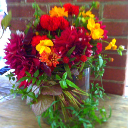
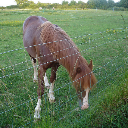
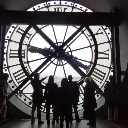
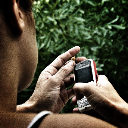
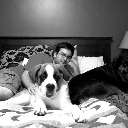
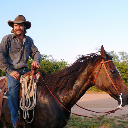
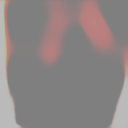
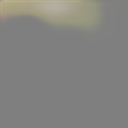
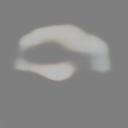
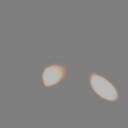
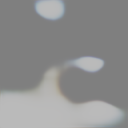
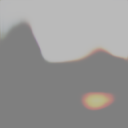

In [11]:

opt = optax.lion(cfg['lr']) if cfg['optimizer'] == 'lion' else optax.adamw(cfg['lr'])
opt_state = opt.init(params)
update = jit(partial(update_fn, opt=opt))

hof = 0

def train(params, opt_state, cfg, batches):
    wandb.init(project="neuroscope", entity="syrkis", config=cfg)
    for step in range(10_000):
        lh, rh, img = next(batches)
        params, opt_state, loss = update(params, img, opt_state)
        losses.append(loss.item())
        info_bar = [f"loss : {loss:.4f}", f"step : {step}", f"hof : {hof}"]
        syrkis.training.plot_multiples(jnp.concatenate([img_sample[:6], apply_fn(params, img_sample)[:6]], axis=0), n_rows=2)
        if step % 20 == 0:
            wandb.log({"loss": loss})
    
train(params, opt_state, cfg, batches)